In [2]:
import psycopg2
import numpy as np
import pandas as pd
import networkx as nx
import pylab

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
import modules.community as comm
import modules.community_quality as commq
import modules.helpers as helpers
import matplotlib.pyplot as plt
from scipy import sparse, linalg
from __future__ import division
import urlparse
import clipboard

In [4]:
%matplotlib inline

In [5]:
def query(myQuery):
    conn = psycopg2.connect(host='', dbname='', user='', password='', port=0)

    cursor = conn.cursor()
    cursor.execute(myQuery)
    cols = [desc[0] for desc in cursor.description]


    records = cursor.fetchall()

    data = np.array(list(records), dtype = str)
    df = pd.DataFrame(data, columns = cols)
    cursor.close()
    
    return df

In [6]:
def create_graph(df,sample_size):
    
    G = nx.Graph(map(lambda x: (x[0], x[1], {'weight': x[2]}),
                    df.head(sample_size).values))
    G = nx.convert_node_labels_to_integers(G, label_attribute='trimmed_url')
        
    return G

In [7]:
def create_digraph(df,sample_size):
    
    G = nx.DiGraph(map(lambda x: (x[0], x[1], {'weight': x[2]}),
                    df.head(sample_size).values))
    G = nx.convert_node_labels_to_integers(G, label_attribute='trimmed_url')
        
    return G

In [8]:
def undirected(df):
    x = []
    y = []
    for i in xrange(len(df)):
        if df['prevproductid'][i] > df['productid'][i]:
            x.append(df['productid'][i])
            y.append(df['prevproductid'][i])
        else:
            x.append(df['prevproductid'][i])
            y.append(df['productid'][i])
    df['x'] = pd.Series(x)
    df['y'] = pd.Series(y)
    
    df = df[['x','y','weights']]
    df.columns = ['prevproductid','productid','weights']
    df = df.groupby(['prevproductid','productid']).sum().reset_index()
    
    return df

In [9]:
def describe_dimpages(dim_product, pages):
    return dim_product[dim_product.productid.isin(pages)]

In [137]:
def list_cluster(graph,idx):
    list_str = []
    for i in graph[idx].nodes():
          list_str.append(str(i))  
    
    return list_str

In [135]:
def df_clusters(graph,idx):
    list_str = list_cluster(graph,idx)
    df = describe_dimpages(dim_product,list_str)
    return df

In [136]:
def print_info(graph,idx):
    print 'Cluster',"%01d" %(idx+1)
    print ""

    df = df_clusters(graph,idx)

    print "PAGENAMES:"
    print ""
    for i in np.sort(list(set(df['pagename'].tolist()))):
        print i
    print ""
    print "==========================================================="

    print "TIER2:" 
    print ""
    for i in np.sort(list(set(df['tier2'].tolist()))):
        print i
    print ""
    print "==========================================================="

    print "BRAND:" 
    print ""
    for i in np.sort(list(set(df['brand'].tolist()))):
        print i
    print ""
    print "==========================================================="
    print "PRICE:" 
    print ""
    p=np.sort([float((i.replace('$','')).replace(',','')) for i in list(df['price'].tolist()) if i <> 'None'])
    print 'n = ',len(p),' ','mean = ',np.round((np.mean(p)),2),' ','median = ',np.round(np.median(p),2),' ','stdev = ',np.round(np.std(p),2)

In [ ]:
q = """
select * from
lookuppage
"""
lookuppage = query(q)

In [11]:
q = """
select * from
dim_product
"""
dim_product = query(q)

## Data: Number of distinct products purchased greater than 50

In [12]:
q = """
select * from pdb_rd_products_gotogether_distinctprod_gt50_weights
"""
purchases_ = query(q)

In [13]:
purchases_[['weights']] = purchases_[['weights']].astype(int)
purchases__v2 = purchases_.sort(['weights'], ascending=[False]).reset_index()

In [14]:
df = purchases__v2

In [15]:
len(df)

227978

In [17]:
undirected = undirected(df)

In [21]:
undirected.sort(['weights'], ascending=[False]).head()

,prevproductid,productid,weights
53403,45526,71850,10
69188,53433,53435,10
95564,69931,71850,8
69189,53433,53436,8
74197,54315,71850,8


In [23]:
len(undirected)

113989

# (A)

In [24]:
g5 = create_graph(undirected,sample_size=len(undirected))

In [25]:
print g5.number_of_nodes(), g5.number_of_edges()

2793 113989


In [27]:
g5_ccs = sorted(nx.connected_component_subgraphs(g5), key=len, reverse=True)
g5_cc0 = nx.convert_node_labels_to_integers(g5_ccs[0])
pos_g5_cc0 = nx.graphviz_layout(g5_cc0)
pos0_g5_cc0 = nx.spectral_layout(g5_cc0)
g5_cc0.number_of_nodes(), g5_cc0.number_of_edges(), g5_cc0.number_of_selfloops()

(2741, 112663, 0)

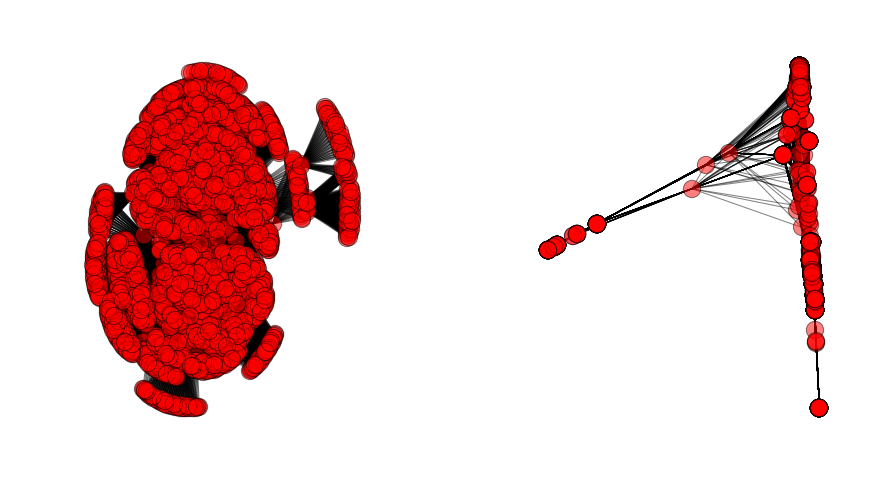

In [28]:
fig, axes = plt.subplots(1, 2, figsize=[15, 8])
nx.draw(g5_cc0, pos_g5_cc0, ax=axes[0], alpha=0.5)
nx.draw(g5_cc0, pos0_g5_cc0, ax=axes[1], alpha=0.5)

In [31]:
g5_cc0_clusters, edges_inc_g5_cc0_clusters, edges_mis_g5_cc0_clusters = \
    helpers.prep_clusters(g5_cc0, helpers.skncuts(g5_cc0, max_ncut_size=0.4, min_ratio=0.1))
print 'number of clusters', len(g5_cc0_clusters)

DONE: ncut_size (0.463094357274) >= max_ncut_size (0.4)
DONE: ncut_size (1.09880979311) >= max_ncut_size (0.4)
DONE: ncut_size (0.457950313023) >= max_ncut_size (0.4)
DONE: ncut_size (1.05484330484) >= max_ncut_size (0.4)
DONE: ncut_size (1.34000556019) >= max_ncut_size (0.4)
DONE: ncut_size (1.05802320928) >= max_ncut_size (0.4)
DONE: ncut_size (1.3245924876) >= max_ncut_size (0.4)
DONE: ncut_size (1.07959487819) >= max_ncut_size (0.4)
DONE: ncut_size (1.33040016761) >= max_ncut_size (0.4)
DONE: ncut_size (1.03900119825) >= max_ncut_size (0.4)
DONE: ncut_size (1.34657210402) >= max_ncut_size (0.4)
DONE: ncut_size (1.07598039216) >= max_ncut_size (0.4)
DONE: ncut_size (1.08971704624) >= max_ncut_size (0.4)
DONE: ncut_size (0.433683222015) >= max_ncut_size (0.4)
DONE: ncut_size (1.06515493536) >= max_ncut_size (0.4)
DONE: ncut_size (1.09938458925) >= max_ncut_size (0.4)
DONE: ncut_size (1.08540281704) >= max_ncut_size (0.4)
DONE: ncut_size (0.448831140567) >= max_ncut_size (0.4)
number 

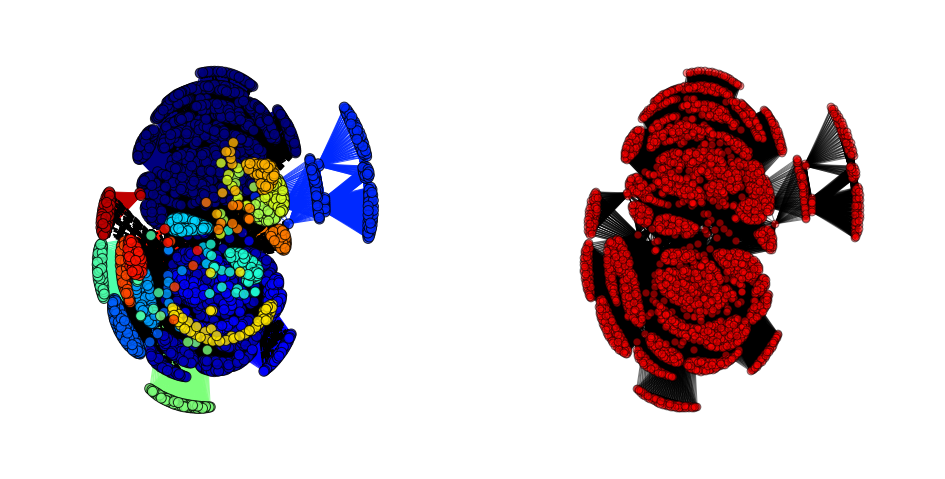

In [32]:
helpers.plot_clusters(g5_cc0, pos_g5_cc0, g5_cc0_clusters, edges_mis_g5_cc0_clusters, plt)

In [33]:
for i in range(len(g5_cc0_clusters)):
    print 'Cluster',i+1, '=', len(g5_cc0_clusters[i].nodes())

Cluster 1 = 926
Cluster 2 = 598
Cluster 3 = 211
Cluster 4 = 145
Cluster 5 = 93
Cluster 6 = 78
Cluster 7 = 70
Cluster 8 = 68
Cluster 9 = 62
Cluster 10 = 62
Cluster 11 = 60
Cluster 12 = 59
Cluster 13 = 53
Cluster 14 = 53
Cluster 15 = 53
Cluster 16 = 51
Cluster 17 = 50
Cluster 18 = 49


In [ ]:
idx = 
df = describe_dimpages(dim_product,list_str)

##### ** will have to cluster again large clusters

## Take a glimpse of some of the smaller set of clusters

### Cluster 5

In [ ]:
idx = 0
print_info(g5_cc0_clusters,idx)

### Cluster 6

In [ ]:
idx = 5
print_info(g5_cc0_clusters,idx)

### Cluster 7

In [ ]:
idx = 17
print_info(g5_cc0_clusters,idx)

## Cluster again Cluster 1 from (A)

In [144]:
pos_c1 = nx.graphviz_layout(g5_cc0_clusters[0])
pos0_c1 = nx.spectral_layout(g5_cc0_clusters[0])
g5_cc0_clusters[0].number_of_nodes(), g5_cc0_clusters[0].number_of_edges(), g5_cc0_clusters[0].number_of_selfloops()

(926, 37472, 0)

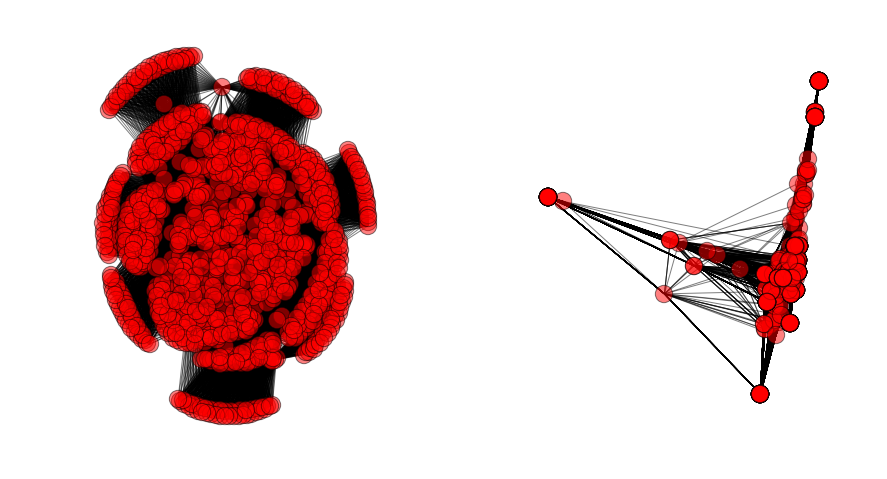

In [145]:
fig, axes = plt.subplots(1, 2, figsize=[15, 8])
nx.draw(g5_cc0_clusters[0], pos_c1, ax=axes[0], alpha=0.5)
nx.draw(g5_cc0_clusters[0], pos0_c1, ax=axes[1], alpha=0.5)

In [147]:
g5_c1_clusters, edges_inc_g5_c1_clusters, edges_mis_g5_c1_clusters = \
    helpers.prep_clusters(g5_cc0_clusters[0], helpers.skncuts(g5_cc0_clusters[0], max_ncut_size=0.8, min_ratio=0.1))
print 'number of clusters', len(g5_c1_clusters)

DONE: ncut_size (1.09551859552) >= max_ncut_size (0.8)
DONE: ncut_size (1.34054054054) >= max_ncut_size (0.8)
DONE: ncut_size (1.12012743628) >= max_ncut_size (0.8)
DONE: ncut_size (1.10795454545) >= max_ncut_size (0.8)
DONE: ncut_size (1.10089399745) >= max_ncut_size (0.8)
DONE: ncut_size (1.35842293907) >= max_ncut_size (0.8)
DONE: ncut_size (1.15476190476) >= max_ncut_size (0.8)
DONE: ncut_size (1.07354925776) >= max_ncut_size (0.8)
DONE: ncut_size (1.10024982966) >= max_ncut_size (0.8)
DONE: ncut_size (1.13428571429) >= max_ncut_size (0.8)
DONE: ncut_size (1.16138763198) >= max_ncut_size (0.8)
DONE: ncut_size (1.08436718564) >= max_ncut_size (0.8)
DONE: ncut_size (1.1063450863) >= max_ncut_size (0.8)
DONE: ncut_size (1.09212903454) >= max_ncut_size (0.8)
DONE: ncut_size (1.1061505508) >= max_ncut_size (0.8)
DONE: ncut_size (0.925831835442) >= max_ncut_size (0.8)
DONE: ncut_size (1.14030520512) >= max_ncut_size (0.8)
DONE: ncut_size (1.07094804763) >= max_ncut_size (0.8)
DONE: ncut_

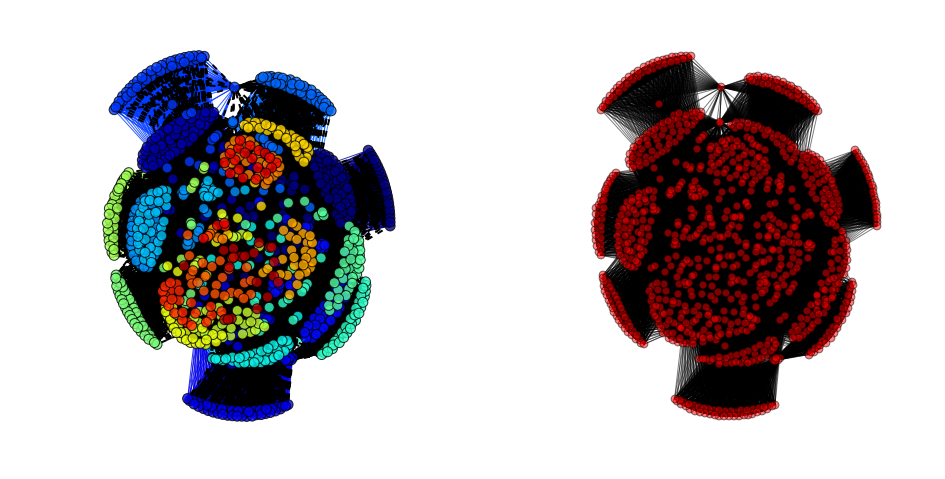

In [148]:
helpers.plot_clusters(g5_cc0_clusters[0], pos_c1, g5_c1_clusters, edges_mis_g5_c1_clusters, plt)

In [149]:
for i in range(len(g5_c1_clusters)):
    print 'Cluster',i+1, '=', len(g5_c1_clusters[i].nodes())

Cluster 1 = 106
Cluster 2 = 73
Cluster 3 = 59
Cluster 4 = 50
Cluster 5 = 50
Cluster 6 = 49
Cluster 7 = 48
Cluster 8 = 43
Cluster 9 = 43
Cluster 10 = 43
Cluster 11 = 41
Cluster 12 = 39
Cluster 13 = 38
Cluster 14 = 36
Cluster 15 = 31
Cluster 16 = 30
Cluster 17 = 28
Cluster 18 = 28
Cluster 19 = 26
Cluster 20 = 23
Cluster 21 = 22
Cluster 22 = 20


## Just to get a glimpse of some of the clusters. Here are Clusters 1-3:

### Cluster 1

In [ ]:
idx = 0
print_info(g5_c1_clusters,idx)

### Cluster 2

In [ ]:
idx = 1
print_info(g5_c1_clusters,idx)

### Cluster 3

In [ ]:
idx = 2
print_info(g5_c1_clusters,idx)

## Cluster again Cluster 2 from (A)

In [156]:
pos_c2 = nx.graphviz_layout(g5_cc0_clusters[1])
pos0_c2 = nx.spectral_layout(g5_cc0_clusters[1])
g5_cc0_clusters[1].number_of_nodes(), g5_cc0_clusters[1].number_of_edges(), g5_cc0_clusters[1].number_of_selfloops()

(598, 23726, 0)

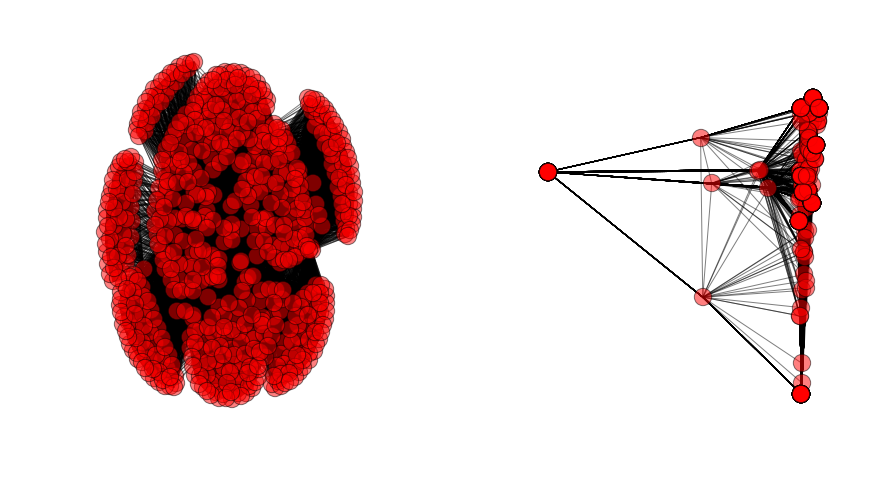

In [157]:
fig, axes = plt.subplots(1, 2, figsize=[15, 8])
nx.draw(g5_cc0_clusters[1], pos_c2, ax=axes[0], alpha=0.5)
nx.draw(g5_cc0_clusters[1], pos0_c2, ax=axes[1], alpha=0.5)

In [168]:
g5_c2_clusters, edges_inc_g5_c2_clusters, edges_mis_g5_c2_clusters = \
    helpers.prep_clusters(g5_cc0_clusters[1], helpers.skncuts(g5_cc0_clusters[1], max_ncut_size=0.458, min_ratio=0.1))
print 'number of clusters', len(g5_c2_clusters)

DONE: ncut_size (1.11154594354) >= max_ncut_size (0.458)
DONE: ncut_size (1.06337422833) >= max_ncut_size (0.458)
DONE: ncut_size (1.17201421522) >= max_ncut_size (0.458)
DONE: ncut_size (0.513486102736) >= max_ncut_size (0.458)
DONE: ncut_size (1.06563307494) >= max_ncut_size (0.458)
DONE: ncut_size (1.10892857143) >= max_ncut_size (0.458)
DONE: ncut_size (1.06076491179) >= max_ncut_size (0.458)
DONE: ncut_size (1.06276647728) >= max_ncut_size (0.458)
DONE: ncut_size (1.12862587503) >= max_ncut_size (0.458)
DONE: ncut_size (1.03678247734) >= max_ncut_size (0.458)
number of clusters 10


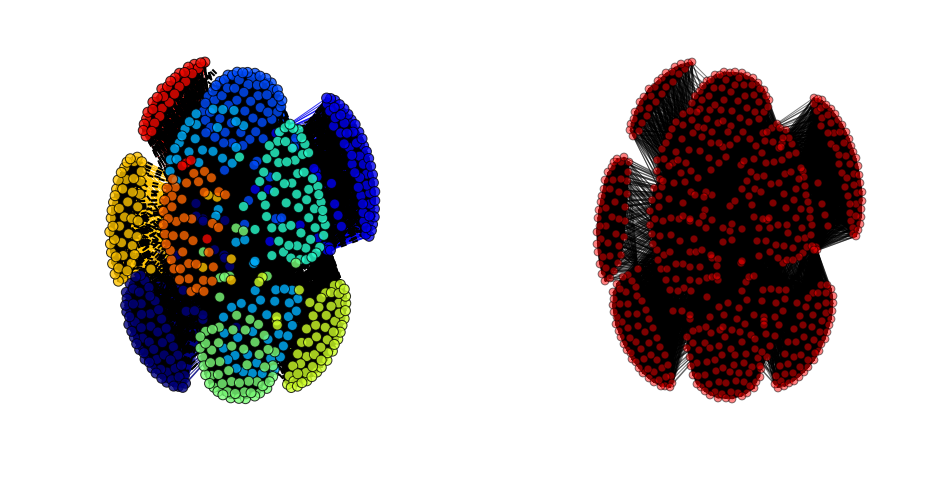

In [169]:
helpers.plot_clusters(g5_cc0_clusters[1], pos_c2, g5_c2_clusters, edges_mis_g5_c2_clusters, plt)

In [170]:
for i in range(len(g5_c2_clusters)):
    print 'Cluster',i+1, '=', len(g5_c2_clusters[i].nodes())

Cluster 1 = 74
Cluster 2 = 71
Cluster 3 = 71
Cluster 4 = 66
Cluster 5 = 65
Cluster 6 = 62
Cluster 7 = 60
Cluster 8 = 52
Cluster 9 = 44
Cluster 10 = 33


## Just to get a glimpse of some of the clusters. Here are Clusters 1-5:

### Cluster 1

In [ ]:
idx = 0
print_info(g5_c2_clusters,idx)

### Cluster 2

In [ ]:
idx = 1
print_info(g5_c1_clusters,idx)

### Cluster 3

In [ ]:
idx = 2
print_info(g5_c1_clusters,idx)